# FTDI Device Info

In [1]:
from pyftdi.ftdi import Ftdi

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:
    for entry in devices:
        try:
            # entry can be (UsbDeviceDescriptor, interface) or similar
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            # UsbDeviceDescriptor fields
            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04x}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04x}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : {serial or 'Unknown'}")
            print(f"   Description : {description or 'Unknown'}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : ￿￿￿￿￿￿￿￿
   Description : ￿￿￿￿￿￿
   Interfaces  : 1



In [2]:
from pyftdi.ftdi import Ftdi

def safe_to_hex_string(value):
    """Return UTF-8 string if printable, else show hex representation."""
    if value is None:
        return 'None'
    try:
        if all(0x20 <= ord(c) <= 0x7E for c in value):
            return value  # printable ASCII
        else:
            raise UnicodeEncodeError
    except Exception:
        return ' '.join(f'{ord(c):02X}' for c in value)

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:
    for entry in devices:
        try:
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04X}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04X}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : 0x{safe_to_hex_string(serial)}")
            print(f"   Description : 0x{safe_to_hex_string(description)}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : 0xFFFF FFFF FFFF FFFF FFFF FFFF FFFF FFFF
   Description : 0xFFFF FFFF FFFF FFFF FFFF FFFF
   Interfaces  : 1



# FTDI FT232H Sanity Test

In [3]:
from pyftdi.ftdi import Ftdi
from pyftdi.i2c import I2cController
from IPython.display import display, Markdown
import traceback

'''
Bus Rate
-  100 kHz ... default
-  400 kHz
- 1000 kHz
'''

BUS_RATE = 4e5


display(Markdown("## 🔍 FT232H Sanity Test"))

try:
    display(Markdown("**🔹 Scanning for FTDI devices...**"))
    Ftdi.show_devices()
except Exception as e:
    display(Markdown(f"❌ **Could not list FTDI devices:** `{e}`"))
    traceback.print_exc()
else:
    try:
        display(Markdown("**🔹 Initializing I2C interface...**"))
        i2c = I2cController()
        i2c.configure('ftdi://ftdi:232h/1', frequency=BUS_RATE) 


        freq = i2c.frequency
        display(Markdown(f"✅ **Connected to FT232H via I2C** at **{freq/1000:.1f} kHz**"))

        # ✅ Manually scan I2C addresses 0x03–0x77
        display(Markdown("**🔹 Scanning I2C bus...**"))
        found = []
        for addr in range(0x03, 0x78):
            try:
                port = i2c.get_port(addr)
                port.read(1)  # Try reading one byte (safe test)
                found.append(addr)
            except Exception:
                # No device responded
                pass

        if found:
            md = "\n".join([f"- `0x{addr:02X}`" for addr in found])
            display(Markdown(f"✅ **Found I2C devices:**\n{md}"))
        else:
            display(Markdown("⚠️ **No I2C devices detected.** Check wiring or power."))

        i2c.terminate()
        display(Markdown("✅ **Test complete — FT232H is working properly.**"))

    except Exception as e:
        display(Markdown(f"❌ **Failed to communicate with FT232H:** `{e}`"))
        traceback.print_exc()


## 🔍 FT232H Sanity Test

**🔹 Scanning for FTDI devices...**

Available interfaces:
  ftdi://ftdi:232h:1/1  (￿￿￿￿￿￿)



**🔹 Initializing I2C interface...**

✅ **Connected to FT232H via I2C** at **1000.0 kHz**

**🔹 Scanning I2C bus...**

✅ **Found I2C devices:**
- `0x68`

✅ **Test complete — FT232H is working properly.**

# MPU6050

In [4]:
from pyftdi.i2c import I2cController
import struct, time, sys

# --- MPU-6050 constants ---
MPU_ADDR      = 0x68
PWR_MGMT_1    = 0x6B
ACCEL_XOUT_H  = 0x3B

BUS_RATE = 4e5

# --- Initialize I2C via FT232H ---
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1?frequency={}'.format(BUS_RATE))  
mpu = i2c.get_port(MPU_ADDR)

# --- Wake up sensor ---
mpu.write_to(PWR_MGMT_1, b'\x00')
time.sleep(0.1)

# --- Read and convert raw data ---
def read_mpu6050():
    raw = mpu.exchange([ACCEL_XOUT_H], 14)
    ax, ay, az, temp, gx, gy, gz = struct.unpack('>hhhhhhh', raw)
    return {
        'ax': ax / 16384.0,  # g
        'ay': ay / 16384.0,
        'az': az / 16384.0,
        'gx': gx / 131.0,    # °/s
        'gy': gy / 131.0,
        'gz': gz / 131.0,
        'temp': temp / 340.0 + 36.53
    }

# --- Continuous read loop ---
print("Streaming MPU6050 data... (Ctrl+C to stop)\n")
try:
    while True:
        d = read_mpu6050()
        line = (f"A=({d['ax']:+.2f}, {d['ay']:+.2f}, {d['az']:+.2f}) g   "
                f"G=({d['gx']:+6.1f}, {d['gy']:+6.1f}, {d['gz']:+6.1f}) °/s   "
                f"T={d['temp']:.2f} °C\r")
        sys.stdout.write(line)
        sys.stdout.flush()
        time.sleep(0.05)  # ~20 Hz refresh
except KeyboardInterrupt:
    print("\nStopped by user.")
finally:
    i2c.terminate()


Streaming MPU6050 data... (Ctrl+C to stop)

A=(+1.01, -0.01, -0.26) g   G=(  -1.2,   +0.6,   +1.4) °/s   T=22.27 °C
Stopped by user.


In [138]:
from pyftdi.i2c import I2cController
import struct, time

MPU_ADDR = 0x68

# MPU-6050 Register Map
REG_PWR_MGMT_1   = 0x6B
REG_SMPLRT_DIV   = 0x19
REG_CONFIG       = 0x1A   # DLPF_CFG
REG_GYRO_CONFIG  = 0x1B
REG_ACCEL_CONFIG = 0x1C
REG_FIFO_EN      = 0x23
REG_USER_CTRL    = 0x6A
REG_PWR_MGMT_2   = 0x6C
REG_WHO_AM_I     = 0x75

# Initialize FT232H I2C
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1?frequency=400000')
mpu = i2c.get_port(MPU_ADDR)

print(f"✅ Connected to FT232H. Scanning for MPU-6050 at 0x{MPU_ADDR:02X}...\n")

try:
    # --- Helpers ---
    def write_reg(port, reg, value):
        """Write one byte to a register"""
        port.write([reg, value & 0xFF])
        time.sleep(0.01)

    def read_reg(port, reg):
        """Read one byte from a register"""
        raw = port.read_from(reg, 1)
        return raw[0]

    def read_whoami(port):
        whoami = read_reg(port, REG_WHO_AM_I)
        print(f"🆔 WHO_AM_I: 0x{whoami:02X} {'✅ OK' if whoami == 0x68 else '⚠️ Unexpected'}")

    # --- Write configuration ---
    def write_config(port,
                     dlpf_cfg=3,          # DLPF bandwidth (0–6)
                     gyro_fs_sel=0,       # Gyro full-scale ±250–2000 °/s
                     accel_fs_sel=0,      # Accel full-scale ±2–16 g
                     fifo_enable=True,
                     dmp_enable=False):
        """
        Configure MPU6050: DLPF, gyro/accel ranges, FIFO, DMP, etc.
        """

        print("🛠️ Writing configuration to MPU-6050...\n")

        # Wake up device
        write_reg(port, REG_PWR_MGMT_1, 0x00)

        # Set DLPF
        write_reg(port, REG_CONFIG, dlpf_cfg & 0x07)

        # Gyro full-scale range
        gyro_val = (gyro_fs_sel & 0x03) << 3
        write_reg(port, REG_GYRO_CONFIG, gyro_val)

        # Accel full-scale range
        accel_val = (accel_fs_sel & 0x03) << 3
        write_reg(port, REG_ACCEL_CONFIG, accel_val)

        # FIFO Enable
        fifo_val = 0x78 if fifo_enable else 0x00  # Enable all gyro+accel
        write_reg(port, REG_FIFO_EN, fifo_val)

        # USER_CTRL (DMP/FIFO control)
        user_ctrl = (0x40 if fifo_enable else 0x00) | (0x80 if dmp_enable else 0x00)
        write_reg(port, REG_USER_CTRL, user_ctrl)

        print(f"✅ DLPF_CFG  : {dlpf_cfg} → bandwidth config")
        print(f"✅ GYRO FS   : ±{[250,500,1000,2000][gyro_fs_sel]} °/s")
        print(f"✅ ACCEL FS  : ±{[2,4,8,16][accel_fs_sel]} g")
        print(f"✅ FIFO_EN   : {'ON' if fifo_enable else 'OFF'}")
        print(f"✅ DMP_EN    : {'ON' if dmp_enable else 'OFF'}")

    # --- Read & decode configuration ---
    def read_config(port):
        """Read and decode MPU6050 config registers."""
        print("\n📖 Reading MPU-6050 configuration...\n")

        dlpf_cfg = read_reg(port, REG_CONFIG) & 0x07
        gyro_cfg = (read_reg(port, REG_GYRO_CONFIG) >> 3) & 0x03
        accel_cfg = (read_reg(port, REG_ACCEL_CONFIG) >> 3) & 0x03
        fifo_en = read_reg(port, REG_FIFO_EN)
        user_ctrl = read_reg(port, REG_USER_CTRL)

        dlpf_table = {
            0: "256 Hz (fastest, low delay)",
            1: "188 Hz",
            2: "98 Hz",
            3: "42 Hz (balanced)",
            4: "20 Hz",
            5: "10 Hz",
            6: "5 Hz (max smoothing)",
        }

        gyro_range = ["±250°/s", "±500°/s", "±1000°/s", "±2000°/s"]
        accel_range = ["±2g", "±4g", "±8g", "±16g"]

        print(f"🧠 DLPF_CFG   : {dlpf_cfg} → {dlpf_table.get(dlpf_cfg,'Reserved')}")
        print(f"🧭 Gyro Range : {gyro_range[gyro_cfg]}")
        print(f"   Accel Range: {accel_range[accel_cfg]}")
        print(f"📦 FIFO_EN    : 0x{fifo_en:02X} ({'Enabled' if fifo_en else 'Disabled'})")
        print(f"⚙️  USER_CTRL : 0x{user_ctrl:02X} "
              f"(FIFO={'ON' if user_ctrl & 0x40 else 'OFF'}, "
              f"DMP={'ON' if user_ctrl & 0x80 else 'OFF'})")

    # --- Execute sequence ---
    read_whoami(mpu)

    write_config(
        mpu,
        dlpf_cfg=6, #3,         # 42 Hz filter
        gyro_fs_sel=0,      # ±250 °/s
        accel_fs_sel=0,     # ±2 g
        fifo_enable=True,
        dmp_enable=False
    )

    read_config(mpu)

except Exception as e:
    print(f"❌ Could not communicate with MPU-6050: {e}")

finally:
    i2c.terminate()
    print("\n🔚 I2C connection closed.")


✅ Connected to FT232H. Scanning for MPU-6050 at 0x68...

🆔 WHO_AM_I: 0x68 ✅ OK
🛠️ Writing configuration to MPU-6050...

✅ DLPF_CFG  : 6 → bandwidth config
✅ GYRO FS   : ±250 °/s
✅ ACCEL FS  : ±2 g
✅ FIFO_EN   : ON
✅ DMP_EN    : OFF

📖 Reading MPU-6050 configuration...

🧠 DLPF_CFG   : 6 → 5 Hz (max smoothing)
🧭 Gyro Range : ±250°/s
   Accel Range: ±2g
📦 FIFO_EN    : 0x78 (Enabled)
⚙️  USER_CTRL : 0x40 (FIFO=ON, DMP=OFF)

🔚 I2C connection closed.


# FIFO

- On each I2C read, all complete 6 DoF samples in the FIFO are transmitted

In [248]:
from pyftdi.i2c import I2cController
import struct, time, sys

MPU_ADDR = 0x68

# Registers
REG_SMPLRT_DIV   = 0x19
REG_CONFIG       = 0x1A
REG_GYRO_CONFIG  = 0x1B
REG_ACCEL_CONFIG = 0x1C
REG_FIFO_EN      = 0x23
REG_INT_ENABLE   = 0x38
REG_INT_STATUS   = 0x3A
REG_USER_CTRL    = 0x6A
REG_PWR_MGMT_1   = 0x6B
REG_PWR_MGMT_2   = 0x6C
REG_FIFO_COUNTH  = 0x72
REG_FIFO_COUNTL  = 0x73
REG_FIFO_R_W     = 0x74
REG_WHO_AM_I     = 0x75

# Scales
ACCEL_SCALE = 16384.0  # ±2 g
GYRO_SCALE  = 131.0    # ±250 °/s

BUS_RATE = 4e5

data_log = []

# I2C
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1?frequency={BUS_RATE}')  # use 100k if you prefer
mpu = i2c.get_port(MPU_ADDR)

# ---- helpers (use exchange()/write_to like your working code) ----
def write8(reg, val):
    mpu.write_to(reg, bytes([val & 0xFF]))
    time.sleep(0.002)

def read8(reg):
    return mpu.exchange([reg], 1)[0]

def read16_be(reg):
    return struct.unpack('>H', mpu.exchange([reg], 2))[0]

def fifo_read(nbytes):
    # IMPORTANT: use exchange with the FIFO register address
    return mpu.exchange([REG_FIFO_R_W], nbytes)

def fifo_reset():
    # toggle reset bit then clear
    write8(REG_USER_CTRL, read8(REG_USER_CTRL) | 0x04)
    time.sleep(0.01)
    write8(REG_USER_CTRL, read8(REG_USER_CTRL) & ~0x04)
    time.sleep(0.01)

def dump_regs():
    regs = [
        ("WHO_AM_I",     REG_WHO_AM_I),
        ("PWR_MGMT_1",   REG_PWR_MGMT_1),
        ("PWR_MGMT_2",   REG_PWR_MGMT_2),
        ("CONFIG",       REG_CONFIG),
        ("SMPLRT_DIV",   REG_SMPLRT_DIV),
        ("GYRO_CONFIG",  REG_GYRO_CONFIG),
        ("ACCEL_CONFIG", REG_ACCEL_CONFIG),
        ("USER_CTRL",    REG_USER_CTRL),
        ("FIFO_EN",      REG_FIFO_EN),
        ("INT_ENABLE",   REG_INT_ENABLE),
        ("INT_STATUS",   REG_INT_STATUS),
    ]
    print("\n🔎 Register dump:")
    for name, r in regs:
        print(f"   {name:<14}= 0x{read8(r):02X}")
    print()

def init_mpu_soft_fifo():
    # No hard reset: many clones NACK after 0x80 reset. Keep it simple.
    write8(REG_PWR_MGMT_1, 0x01)      # PLL X-gyro
    write8(REG_PWR_MGMT_2, 0x00)      # all sensors ON
    time.sleep(0.05)

    # Basic config
    write8(REG_CONFIG, 0x03)          # DLPF 42 Hz
    write8(REG_SMPLRT_DIV, 0x04)      # 1kHz/(1+4) = 200 Hz
    write8(REG_GYRO_CONFIG, 0x00)     # ±250 °/s
    write8(REG_ACCEL_CONFIG, 0x00)    # ±2 g

    # Ensure FIFO & DMP/I2C master are off, then reset FIFO
    write8(REG_USER_CTRL, 0x00)
    write8(REG_FIFO_EN, 0x00)
    fifo_reset()

    # Give ADC a moment to start producing valid samples
    time.sleep(0.05)

    # Enable FIFO logic and select accel+gyro
    write8(REG_USER_CTRL, 0x40)       # FIFO_EN bit (logic enable)
    write8(REG_FIFO_EN, 0x78)         # TEMP=0, XG|YG|ZG|ACCEL=1
    write8(REG_INT_ENABLE, 0x01)      # data-ready interrupt (optional)

    # Clear any stale interrupt
    _ = read8(REG_INT_STATUS)

def stream_fifo():
    print("📡 Streaming FIFO data (Ctrl+C to stop)\n")

    t0 = time.time()
    last_print = 0
    data_log = []

    try:
        while True:
            fifo_count = read16_be(REG_FIFO_COUNTH)

            if fifo_count > 1020:
                fifo_reset()
                continue
            if fifo_count < 12:
                time.sleep(0.005)
                continue

            to_read = (fifo_count // 12) * 12
            blob = fifo_read(to_read)

            for i in range(0, len(blob), 12):
                ax, ay, az, gx, gy, gz = struct.unpack('>hhhhhh', blob[i:i+12])
                axf, ayf, azf = ax/ACCEL_SCALE, ay/ACCEL_SCALE, az/ACCEL_SCALE
                gxf, gyf, gzf = gx/GYRO_SCALE, gy/GYRO_SCALE, gz/GYRO_SCALE

                data_log.append({
                    't': time.time(),
                    'ax': axf, 'ay': ayf, 'az': azf,
                    'gx': gxf, 'gy': gyf, 'gz': gzf
                })

            # ✅ only print every 0.1 s
            now = time.time()
            if now - last_print >= 0.01:
                last_print = now
                sys.stdout.write(
                    f"\rA=({axf:+.2f},{ayf:+.2f},{azf:+.2f}) g  "
                    f"G=({gxf:+6.1f},{gyf:+6.1f},{gzf:+6.1f}) °/s     "
                )
                sys.stdout.flush()

    except KeyboardInterrupt:
        print("\n🛑 Stopped by user.")
    finally:
        print(f"📦 Recorded {len(data_log)} samples.")
        return data_log

       

try:
    who = read8(REG_WHO_AM_I)
    print(f"🆔 WHO_AM_I = 0x{who:02X}")
    if who != 0x68:
        print("⚠️ Unexpected WHO_AM_I (check address AD0/wiring)")

    print("🛠️ Initializing (soft init, no hard reset)...")
    init_mpu_soft_fifo()
    dump_regs()

    # Quick sanity: make sure FIFO_count rises
    for t in (0.05, 0.10, 0.20):
        time.sleep(t)
        cnt = read16_be(REG_FIFO_COUNTH)
        print(f"FIFO count @ +{int(t*1000)} ms: {cnt}")

    data_log = stream_fifo()

except KeyboardInterrupt:
    print("\n🛑 Stopped by user.")
except Exception as e:
    print(f"\n❌ Communication error: {e}")
finally:
    # Clean shutdown
    try:
        write8(REG_FIFO_EN, 0x00)
        write8(REG_USER_CTRL, read8(REG_USER_CTRL) & ~0x40)
    except Exception:
        pass
    i2c.terminate()
    print("🔚 FIFO disabled, I²C connection closed.")


🆔 WHO_AM_I = 0x68
🛠️ Initializing (soft init, no hard reset)...

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x01

FIFO count @ +50 ms: 792
FIFO count @ +100 ms: 1024
FIFO count @ +200 ms: 1024
📡 Streaming FIFO data (Ctrl+C to stop)

A=(+1.02,-0.00,-0.28) g  G=(  -1.4,  +0.5,  +1.5) °/s     
🛑 Stopped by user.
📦 Recorded 8994 samples.
🔚 FIFO disabled, I²C connection closed.


### Add Temperature

In [250]:
from pyftdi.i2c import I2cController
import struct, time, sys

MPU_ADDR = 0x68

# Registers
REG_SMPLRT_DIV   = 0x19
REG_CONFIG       = 0x1A
REG_GYRO_CONFIG  = 0x1B
REG_ACCEL_CONFIG = 0x1C
REG_FIFO_EN      = 0x23
REG_INT_ENABLE   = 0x38
REG_INT_STATUS   = 0x3A
REG_USER_CTRL    = 0x6A
REG_PWR_MGMT_1   = 0x6B
REG_PWR_MGMT_2   = 0x6C
REG_FIFO_COUNTH  = 0x72
REG_FIFO_COUNTL  = 0x73
REG_FIFO_R_W     = 0x74
REG_WHO_AM_I     = 0x75

# Scales
ACCEL_SCALE = 16384.0  # ±2 g
GYRO_SCALE  = 131.0    # ±250 °/s

BUS_RATE = 4e5

data_log = []

# I2C
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1?frequency={BUS_RATE}')  # use 100k if you prefer
mpu = i2c.get_port(MPU_ADDR)

# ---- helpers (use exchange()/write_to like your working code) ----
def write8(reg, val):
    mpu.write_to(reg, bytes([val & 0xFF]))
    time.sleep(0.002)

def read8(reg):
    return mpu.exchange([reg], 1)[0]

def read16_be(reg):
    return struct.unpack('>H', mpu.exchange([reg], 2))[0]

def fifo_read(nbytes):
    # IMPORTANT: use exchange with the FIFO register address
    return mpu.exchange([REG_FIFO_R_W], nbytes)

def fifo_reset():
    # toggle reset bit then clear
    write8(REG_USER_CTRL, read8(REG_USER_CTRL) | 0x04)
    time.sleep(0.01)
    write8(REG_USER_CTRL, read8(REG_USER_CTRL) & ~0x04)
    time.sleep(0.01)

def dump_regs():
    regs = [
        ("WHO_AM_I",     REG_WHO_AM_I),
        ("PWR_MGMT_1",   REG_PWR_MGMT_1),
        ("PWR_MGMT_2",   REG_PWR_MGMT_2),
        ("CONFIG",       REG_CONFIG),
        ("SMPLRT_DIV",   REG_SMPLRT_DIV),
        ("GYRO_CONFIG",  REG_GYRO_CONFIG),
        ("ACCEL_CONFIG", REG_ACCEL_CONFIG),
        ("USER_CTRL",    REG_USER_CTRL),
        ("FIFO_EN",      REG_FIFO_EN),
        ("INT_ENABLE",   REG_INT_ENABLE),
        ("INT_STATUS",   REG_INT_STATUS),
    ]
    print("\n🔎 Register dump:")
    for name, r in regs:
        print(f"   {name:<14}= 0x{read8(r):02X}")
    print()

def init_mpu_soft_fifo():
    # No hard reset: many clones NACK after 0x80 reset. Keep it simple.
    write8(REG_PWR_MGMT_1, 0x01)      # PLL X-gyro
    write8(REG_PWR_MGMT_2, 0x00)      # all sensors ON
    time.sleep(0.05)

    # Basic config
    write8(REG_CONFIG, 0x03)          # DLPF 42 Hz
    write8(REG_SMPLRT_DIV, 0x04)      # 1kHz/(1+4) = 200 Hz
    write8(REG_GYRO_CONFIG, 0x00)     # ±250 °/s
    write8(REG_ACCEL_CONFIG, 0x00)    # ±2 g

    # Ensure FIFO & DMP/I2C master are off, then reset FIFO
    write8(REG_USER_CTRL, 0x00)
    write8(REG_FIFO_EN, 0x00)
    fifo_reset()

    # Give ADC a moment to start producing valid samples
    time.sleep(0.05)

    # Enable FIFO logic and select accel+gyro
    write8(REG_USER_CTRL, 0x40)       # FIFO_EN bit (logic enable)
    write8(REG_FIFO_EN, 0x78)         # TEMP=0, XG|YG|ZG|ACCEL=1
    write8(REG_INT_ENABLE, 0x01)      # data-ready interrupt (optional)

    # Clear any stale interrupt
    _ = read8(REG_INT_STATUS)

def stream_fifo():
    print("📡 Streaming FIFO data (Ctrl+C to stop)\n")

    t0 = time.time()
    last_print = 0
    data_log = []

    try:
        while True:
            fifo_count = read16_be(REG_FIFO_COUNTH)

            if fifo_count > 1020:
                fifo_reset()
                continue
            if fifo_count < 12:
                time.sleep(0.005)
                continue

            # Read temperature once per batch
            # raw = read16_be(0x41)
            # raw = ((raw << 8) & 0xFF00) | ((raw >> 8) & 0x00FF)
            # if raw >= 0x8000:
            #     raw -= 0x10000
            # temp_c = raw / 340.0 + 36.53

            h = read8(0x41)   # TEMP_OUT_H
            l = read8(0x42)   # TEMP_OUT_L
            raw = (h << 8) | l
            if raw >= 0x8000:
                raw -= 0x10000
            temp_c = raw / 340.0 + 36.53  # per datasheet

            to_read = (fifo_count // 12) * 12
            blob = fifo_read(to_read)

            for i in range(0, len(blob), 12):
                ax, ay, az, gx, gy, gz = struct.unpack('>hhhhhh', blob[i:i+12])
                axf, ayf, azf = ax/ACCEL_SCALE, ay/ACCEL_SCALE, az/ACCEL_SCALE
                gxf, gyf, gzf = gx/GYRO_SCALE, gy/GYRO_SCALE, gz/GYRO_SCALE

                #azf += 0.27

                data_log.append({
                    't': time.time(),
                    'ax': axf, 'ay': ayf, 'az': azf,
                    'gx': gxf, 'gy': gyf, 'gz': gzf,
                    'temp': temp_c
                })

            now = time.time()
            if now - last_print >= 0.01:
                last_print = now
                sys.stdout.write(
                    f"\rA=({axf:+.2f},{ayf:+.2f},{azf:+.2f}) g  "
                    f"G=({gxf:+6.1f},{gyf:+6.1f},{gzf:+6.1f}) °/s     "
                    f"T={temp_c:0.2f}°C     "
                    f"n_samples={len(data_log)}"
                )
                sys.stdout.flush()

    except KeyboardInterrupt:
        print("\n🛑 Stopped by user.")
    finally:
        print(f"📦 Recorded {len(data_log)} samples.")
        return data_log

       

try:
    who = read8(REG_WHO_AM_I)
    print(f"🆔 WHO_AM_I = 0x{who:02X}")
    if who != 0x68:
        print("⚠️ Unexpected WHO_AM_I (check address AD0/wiring)")

    print("🛠️ Initializing (soft init, no hard reset)...")
    init_mpu_soft_fifo()
    dump_regs()

    # Quick sanity: make sure FIFO_count rises
    for t in (0.05, 0.10, 0.20):
        time.sleep(t)
        cnt = read16_be(REG_FIFO_COUNTH)
        print(f"FIFO count @ +{int(t*1000)} ms: {cnt}")

    data_log = stream_fifo()

except KeyboardInterrupt:
    print("\n🛑 Stopped by user.")
except Exception as e:
    print(f"\n❌ Communication error: {e}")
finally:
    # Clean shutdown
    try:
        write8(REG_FIFO_EN, 0x00)
        write8(REG_USER_CTRL, read8(REG_USER_CTRL) & ~0x40)
    except Exception:
        pass
    i2c.terminate()
    print("🔚 FIFO disabled, I²C connection closed.")


🆔 WHO_AM_I = 0x68
🛠️ Initializing (soft init, no hard reset)...

🔎 Register dump:
   WHO_AM_I      = 0x68
   PWR_MGMT_1    = 0x01
   PWR_MGMT_2    = 0x00
   CONFIG        = 0x03
   SMPLRT_DIV    = 0x04
   GYRO_CONFIG   = 0x00
   ACCEL_CONFIG  = 0x00
   USER_CTRL     = 0x40
   FIFO_EN       = 0x78
   INT_ENABLE    = 0x01
   INT_STATUS    = 0x01

FIFO count @ +50 ms: 804
FIFO count @ +100 ms: 1024
FIFO count @ +200 ms: 1024
📡 Streaming FIFO data (Ctrl+C to stop)

A=(+1.02,-0.01,-0.27) g  G=(  -1.4,  +0.5,  +1.4) °/s     T=25.24°C     n_samples=7897
🛑 Stopped by user.
📦 Recorded 7897 samples.
🔚 FIFO disabled, I²C connection closed.


📊 Recorded 7897 samples over 39.392 s
⚙️ Expected sample rate: 200.0 Hz → Δt = 5.00 ms
🧠 Inferred actual rate: 200.4 Hz → Δt = 4.99 ms


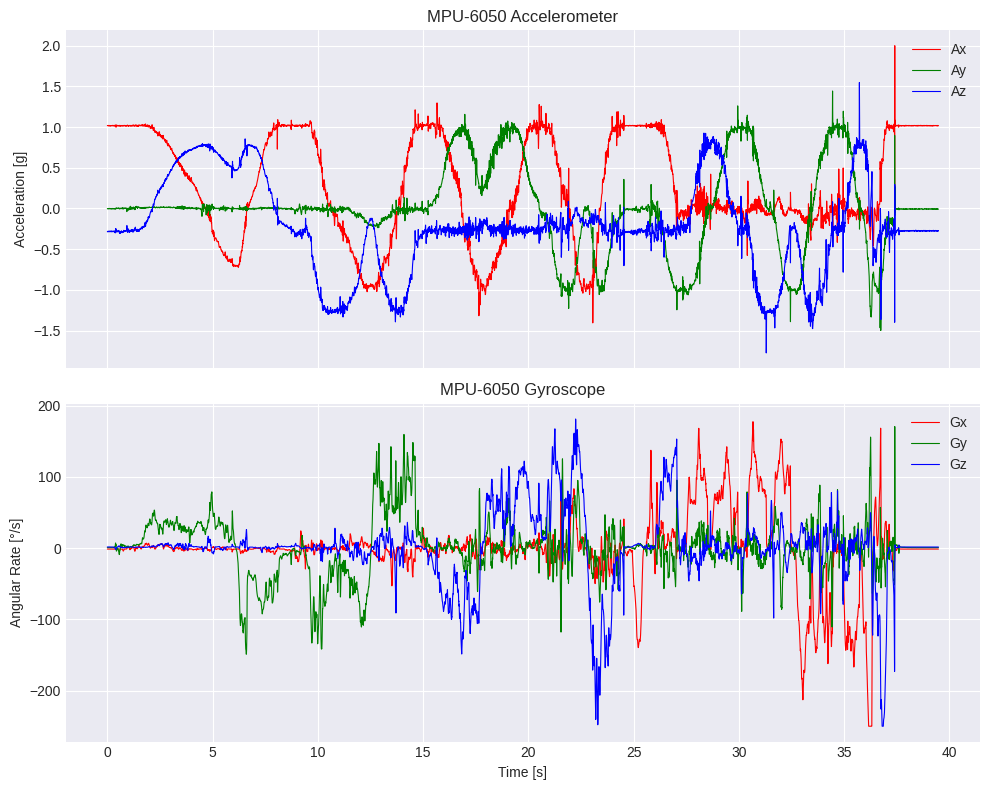

In [251]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mpu6050_dictlog(data_log, sample_rate_hz=200):
    """
    Plot MPU-6050 data when each sample is a dict:
    {'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ...}
    
    Arguments
    ----------
    data_log : list of dicts
        Recorded data points.
    sample_rate_hz : float
        Expected sample rate from the sensor configuration (Hz).
    """
    if not data_log:
        print("⚠️ data_log is empty — nothing to plot.")
        return

    n = len(data_log)

    # Extract recorded timestamps (real host-side times)
    host_t = np.array([d["t"] for d in data_log])
    total_time = host_t[-1] - host_t[0]
    actual_rate = (n - 1) / total_time if total_time > 0 else 0.0
    expected_rate = sample_rate_hz

    print(f"📊 Recorded {n} samples over {total_time:.3f} s")
    print(f"⚙️ Expected sample rate: {expected_rate:.1f} Hz → Δt = {1/expected_rate*1000:.2f} ms")
    print(f"🧠 Inferred actual rate: {actual_rate:.1f} Hz → Δt = {1/actual_rate*1000:.2f} ms")

    # Warn if difference >10%
    if abs(actual_rate - expected_rate) / expected_rate > 0.1:
        print("⚠️ WARNING: inferred rate differs from expected by >10% (host read delay or mis-set SMPLRT_DIV)")

    # Use synthetic uniform time base (true sample spacing)
    dt = 1.0 / expected_rate
    t = np.arange(n) * dt

    # Extract arrays
    ax = np.array([d["ax"] for d in data_log])
    ay = np.array([d["ay"] for d in data_log])
    az = np.array([d["az"] for d in data_log])
    gx = np.array([d["gx"] for d in data_log])
    gy = np.array([d["gy"] for d in data_log])
    gz = np.array([d["gz"] for d in data_log])

    plt.style.use("seaborn-v0_8-darkgrid")
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # --- Accelerometer ---
    axs[0].plot(t, ax, "r-", lw=0.8, label="Ax")
    axs[0].plot(t, ay, "g-", lw=0.8, label="Ay")
    axs[0].plot(t, az, "b-", lw=0.8, label="Az")
    axs[0].set_ylabel("Acceleration [g]")
    axs[0].set_title("MPU-6050 Accelerometer")
    axs[0].legend(loc="upper right")

    # --- Gyroscope ---
    axs[1].plot(t, gx, "r-", lw=0.8, label="Gx")
    axs[1].plot(t, gy, "g-", lw=0.8, label="Gy")
    axs[1].plot(t, gz, "b-", lw=0.8, label="Gz")
    axs[1].set_ylabel("Angular Rate [°/s]")
    axs[1].set_xlabel("Time [s]")
    axs[1].set_title("MPU-6050 Gyroscope")
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

plot_mpu6050_dictlog(data_log)

In [252]:
import pandas as pd
df = pd.DataFrame(data_log)
df

,t,ax,ay,az,gx,gy,gz,temp
0,1.760460e+09,1.017090,-0.001587,-0.284058,-1.480916,0.564885,1.480916,24.938824
1,1.760460e+09,1.017944,-0.003540,-0.283569,-1.442748,0.541985,1.465649,24.938824
2,1.760460e+09,1.017700,-0.003906,-0.281616,-1.435115,0.595420,1.458015,24.938824
3,1.760460e+09,1.018433,-0.004150,-0.281372,-1.435115,0.595420,1.427481,24.938824
4,1.760460e+09,1.017822,-0.001953,-0.286133,-1.442748,0.511450,1.465649,24.938824
...,...,...,...,...,...,...,...,...
7892,1.760460e+09,1.017334,-0.008057,-0.272339,-1.419847,0.549618,1.496183,25.235882
7893,1.760460e+09,1.016724,-0.008911,-0.274292,-1.465649,0.580153,1.473282,25.235882
7894,1.760460e+09,1.016602,-0.009399,-0.274536,-1.442748,0.625954,1.465649,25.235882
7895,1.760460e+09,1.016968,-0.007690,-0.271851,-1.435115,0.610687,1.412214,25.235882


In [253]:
import numpy as np
import pandas as pd

def analyze_mpu6050_stats(data_log, as_dataframe=True, verbose=True):
    """
    Compute descriptive statistics for each signal in a recorded MPU6050 data_log.

    Each entry in data_log must be a dict:
        {'t': ..., 'ax': ..., 'ay': ..., 'az': ..., 'gx': ..., 'gy': ..., 'gz': ...}

    Returns:
        - A dict or pandas.DataFrame with summary stats for each signal.
    """
    if not data_log:
        print("⚠️ data_log is empty — nothing to analyze.")
        return None

    # Extract signals as arrays
    signals = {k: np.array([d[k] for d in data_log]) for k in data_log[0].keys() if k != 't'}

    stats = {}
    for name, arr in signals.items():
        mean = np.mean(arr)
        std = np.std(arr)
        minv = np.min(arr)
        maxv = np.max(arr)
        rms = np.sqrt(np.mean(arr**2))
        peak_to_peak = maxv - minv
        median = np.median(arr)
        mad = np.mean(np.abs(arr - mean))  # mean absolute deviation
        stats[name] = {
            "mean": mean,
            "std": std,
            "min": minv,
            "max": maxv,
            "peak_to_peak": peak_to_peak,
            "median": median,
            "mad": mad,
            "rms": rms,
        }

    # --- Optional: time base sanity ---
    t = np.array([d["t"] for d in data_log])
    duration = t[-1] - t[0]
    rate = len(t) / duration if duration > 0 else 0
    stats["meta"] = {"samples": len(t), "duration_s": duration, "rate_est_Hz": rate}

    if as_dataframe:
        df = pd.DataFrame(stats).T  # transpose for nice row-per-signal format
        if verbose:
            print("📊 MPU-6050 Signal Statistics:\n")
            print(df.round(6))
        return df
    else:
        if verbose:
            print(stats)
        return stats

analyze_mpu6050_stats(data_log)

📊 MPU-6050 Signal Statistics:

           mean        std         min         max  peak_to_peak     median  \
ax     0.279842   0.632684   -1.405518    1.999939      3.405457   0.138062   
ay     0.008134   0.506811   -1.498291    1.443359      2.941650  -0.002563   
az    -0.219501   0.541032   -1.774536    1.548096      3.322632  -0.261841   
gx    -1.037853  49.851182 -250.137405  177.312977    427.450382  -1.328244   
gy     0.463361  39.098761 -149.160305  170.458015    319.618321   0.603053   
gz     1.175768  51.084516 -250.137405  181.129771    431.267176   1.450382   
temp  25.098127   0.162052   24.482941   25.985882      1.502941  25.109412   
meta        NaN        NaN         NaN         NaN           NaN        NaN   

            mad        rms  samples  duration_s  rate_est_Hz  
ax     0.556458   0.691809      NaN         NaN          NaN  
ay     0.327497   0.506876      NaN         NaN          NaN  
az     0.373312   0.583863      NaN         NaN          NaN  
gx   

,mean,std,min,max,peak_to_peak,median,mad,rms,samples,duration_s,rate_est_Hz
ax,0.279842,0.632684,-1.405518,1.999939,3.405457,0.138062,0.556458,0.691809,NaN,NaN,NaN
ay,0.008134,0.506811,-1.498291,1.443359,2.941650,-0.002563,0.327497,0.506876,NaN,NaN,NaN
az,-0.219501,0.541032,-1.774536,1.548096,3.322632,-0.261841,0.373312,0.583863,NaN,NaN,NaN
gx,-1.037853,49.851182,-250.137405,177.312977,427.450382,-1.328244,25.134338,49.861985,NaN,NaN,NaN
gy,0.463361,39.098761,-149.160305,170.458015,319.618321,0.603053,25.995723,39.101507,NaN,NaN,NaN
gz,1.175768,51.084516,-250.137405,181.129771,431.267176,1.450382,27.634849,51.098045,NaN,NaN,NaN
temp,25.098127,0.162052,24.482941,25.985882,1.502941,25.109412,0.102811,25.098650,NaN,NaN,NaN
meta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7897.0,39.392247,200.47092


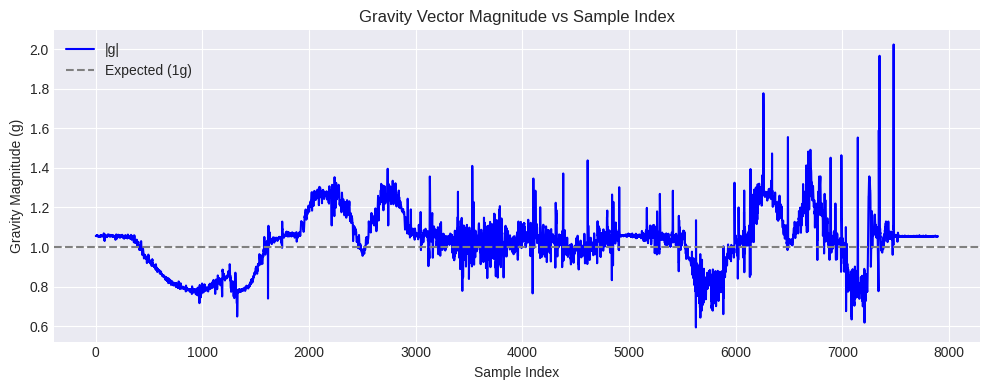

In [254]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gravity_magnitude(data_log):
    """
    Plots the magnitude of the gravity vector ||g|| = sqrt(ax^2 + ay^2 + az^2)
    using sample index on the x-axis.
    """
    # Extract acceleration values
    ax_vals = np.array([d['ax'] for d in data_log])
    ay_vals = np.array([d['ay'] for d in data_log])
    az_vals = np.array([d['az'] for d in data_log])

    # Compute magnitude of the gravity vector
    g_mag = np.sqrt(ax_vals**2 + ay_vals**2 + az_vals**2)

    # X-axis: sample index
    indices = np.arange(len(g_mag))

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(indices, g_mag, label='|g|', color='blue')
    plt.axhline(1.0, color='gray', linestyle='--', label='Expected (1g)')
    plt.xlabel("Sample Index")
    plt.ylabel("Gravity Magnitude (g)")
    plt.title("Gravity Vector Magnitude vs Sample Index")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_gravity_magnitude(data_log)

In [255]:
data_clean = []
magnitude = []
for v in data_log:
    a = np.array([v['ax'], v['ay'], v['az']])
    mag = np.linalg.norm(a)
    magnitude.append(mag)
    if mag < 2.07:
        data_clean.append({'ax':a[0],'ay':a[1],'az':a[2]})
        
    

In [256]:
#magnitude[:20]

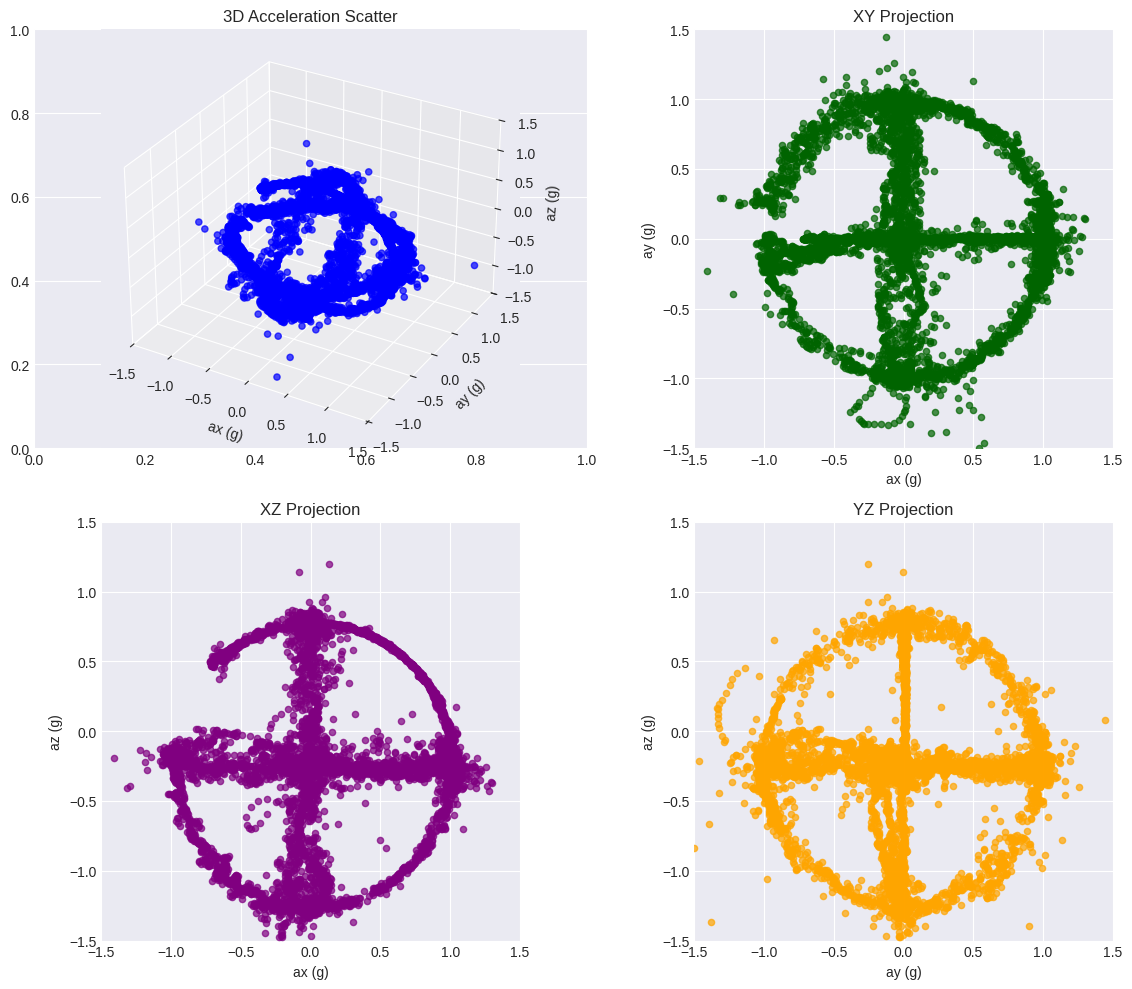

In [258]:
plot_accel_3d_with_projections(data_log)

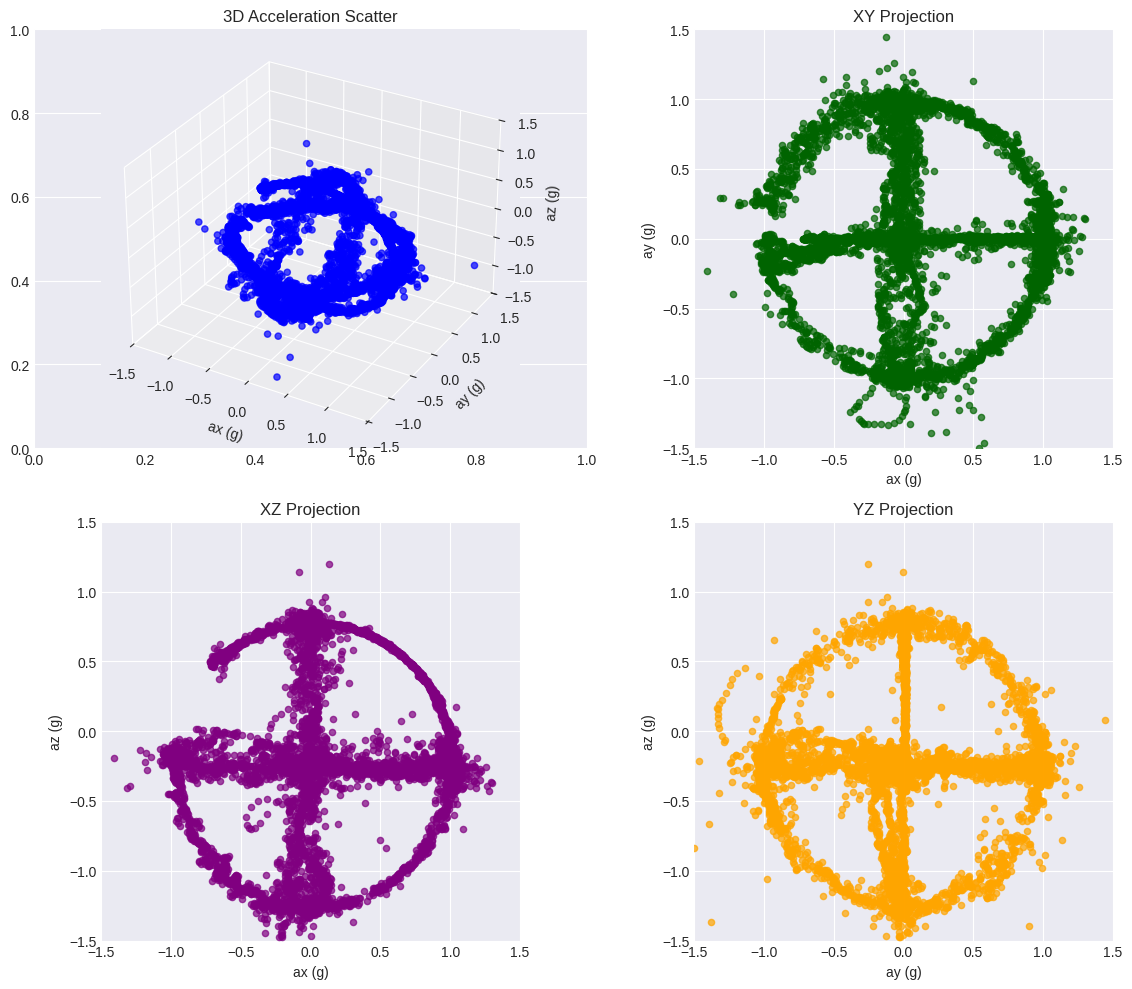

In [259]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_accel_3d_with_projections(data_log):
    """
    Plots 3D acceleration values (ax, ay, az) as dots,
    along with 2D projections on the XY, XZ, and YZ planes.
    All subplots are the same size and aspect ratio is fixed to 1:1.
    """

    val = 1.5
    axis_lim = [-val, val]

    # Extract acceleration data
    ax_vals = [d['ax'] for d in data_log]
    ay_vals = [d['ay'] for d in data_log]
    az_vals = [d['az'] for d in data_log]

    # Create figure with 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()  # Flatten to 1D list for indexed access

    # --- 3D Scatter plot (axs[0]) ---
    ax3d = fig.add_subplot(2, 2, 1, projection='3d')
    ax3d.scatter(ax_vals, ay_vals, az_vals, c='blue', s=20, alpha=0.7)
    ax3d.set_title('3D Acceleration Scatter')
    ax3d.set_xlabel('ax (g)')
    ax3d.set_ylabel('ay (g)')
    ax3d.set_zlabel('az (g)')

    # Set fixed 3D axis limits (optional: symmetrical around 0 or auto-computed)
    ax3d.set_xlim(axis_lim)
    ax3d.set_ylim(axis_lim)
    ax3d.set_zlim(axis_lim)

    # --- 2D Projection: XY (axs[1]) ---
    axs[1].scatter(ax_vals, ay_vals, c='darkgreen', s=20, alpha=0.7)
    axs[1].set_title('XY Projection')
    axs[1].set_xlabel('ax (g)')
    axs[1].set_ylabel('ay (g)')
    axs[1].grid(True)
    axs[1].set_aspect('equal', adjustable='box')
    axs[1].set_xlim(axis_lim)
    axs[1].set_ylim(axis_lim)

    # --- 2D Projection: XZ (axs[2]) ---
    axs[2].scatter(ax_vals, az_vals, c='purple', s=20, alpha=0.7)
    axs[2].set_title('XZ Projection')
    axs[2].set_xlabel('ax (g)')
    axs[2].set_ylabel('az (g)')
    axs[2].grid(True)
    axs[2].set_aspect('equal', adjustable='box')
    axs[2].set_xlim(axis_lim)
    axs[2].set_ylim(axis_lim)

    # --- 2D Projection: YZ (axs[3]) ---
    axs[3].scatter(ay_vals, az_vals, c='orange', s=20, alpha=0.7)
    axs[3].set_title('YZ Projection')
    axs[3].set_xlabel('ay (g)')
    axs[3].set_ylabel('az (g)')
    axs[3].grid(True)
    axs[3].set_aspect('equal', adjustable='box')
    axs[3].set_xlim(axis_lim)
    axs[3].set_ylim(axis_lim)

    plt.tight_layout()
    plt.show()

plot_accel_3d_with_projections(data_log)

# Fit Ellipsoid

In [260]:
import numpy as np

def fit_ellipsoid_constrained(data):
    """
    Fits an ellipsoid to 3D points using an algebraic (constrained) fit,
    then converts the quadric to geometric parameters.

    Returns:
        center: (3,) ellipsoid center
        radii:  (3,) semi-axis lengths (a, b, c), sorted descending
        rotation: (3,3) rotation matrix whose columns are principal axes
    """
    data = np.asarray(data)
    x = data[:, 0][:, None]
    y = data[:, 1][:, None]
    z = data[:, 2][:, None]

    # Design matrix for the general quadric:
    # v = [Axx, Ayy, Azz, Axy, Axz, Ayz, Bx, By, Bz, C]^T
    D = np.hstack([x*x, y*y, z*z, x*y, x*z, y*z, x, y, z, np.ones_like(x)])

    # Algebraic fit: solve D v = 0 with ||v||=1 via SVD (last right-singular vector)
    _, _, vh = np.linalg.svd(D, full_matrices=False)
    v = vh.T[:, -1]

    # Unpack to symmetric form x^T Q x + u^T x + f = 0
    Q = np.array([
        [v[0],   v[3]/2, v[4]/2],
        [v[3]/2, v[1],   v[5]/2],
        [v[4]/2, v[5]/2, v[2]]
    ])
    u = np.array([v[6], v[7], v[8]])
    f = v[9]

    # Ensure Q is invertible
    if np.linalg.matrix_rank(Q) < 3:
        raise ValueError("Fitted quadric is degenerate (Q is not full rank).")

    # Center c = -1/2 Q^{-1} u
    center = -0.5 * np.linalg.solve(Q, u)

    # Scale term k = c^T Q c - f
    k = center @ Q @ center - f

    # If k <= 0 or Q not positive definite, flip global sign
    # (The algebraic solution is up to a scalar factor.)
    eigvals = np.linalg.eigvalsh(Q)
    if k <= 0 or np.any(eigvals <= 0):
        Q = -Q
        u = -u
        f = -f
        center = -0.5 * np.linalg.solve(Q, u)
        k = center @ Q @ center - f
        eigvals = np.linalg.eigvalsh(Q)

    if k <= 0 or np.any(eigvals <= 0):
        raise ValueError("Fitted surface is not an ellipsoid (k<=0 or Q not PD).")

    # Diagonalize Q for axes and rotation
    evals, evecs = np.linalg.eigh(Q)  # Q = evecs @ diag(evals) @ evecs.T
    # Radii from (x')^T diag(evals) (x') = k  ->  x' = evecs^T (x - center)
    radii = np.sqrt(k / evals)

    # Sort axes from largest to smallest for consistency
    order = np.argsort(radii)[::-1]
    radii = radii[order]
    rotation = evecs[:, order]

    return center, radii, rotation


In [280]:
data = np.array([[d['ax'], d['ay'], d['az']] for d in data_log])
center, radii, rotation = fit_ellipsoid_constrained(data)

print("Center:", center)
print("Radii:", radii)
print("Rotation matrix:\n", rotation)


Center: [ 0.01621752 -0.01363289 -0.24506459]
Radii: [1.03639958 1.00833839 0.99473855]
Rotation matrix:
 [[ 0.21692035 -0.81060151 -0.54394002]
 [-0.52788291  0.37130647 -0.76385283]
 [ 0.82114871  0.45283186 -0.34735876]]


In [262]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ellipsoid(center, radii, rotation, raw_data=None, color='cyan', alpha=0.2):
    """
    Plots a 3D ellipsoid with given center, radii, and orientation.
    Optionally overlays raw 3D points.
    """
    # Create a sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Stack and reshape
    sphere = np.stack((x, y, z), axis=-1)  # shape (50, 50, 3)

    # Scale by radii
    ellipsoid = sphere @ np.diag(radii)

    # Rotate
    ellipsoid = ellipsoid @ rotation.T

    # Translate to center
    ellipsoid += center

    # Unpack for plotting
    X = ellipsoid[:, :, 0]
    Y = ellipsoid[:, :, 1]
    Z = ellipsoid[:, :, 2]

    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, rstride=2, cstride=2, color=color, alpha=alpha, linewidth=0)

    # Optional: plot raw data points
    if raw_data is not None:
        ax.scatter(raw_data[:, 0], raw_data[:, 1], raw_data[:, 2], c='black', s=5, alpha=0.6)

    # Axes and formatting
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Fitted Ellipsoid")

    # Equal aspect ratio
    max_radius = np.max(radii)
    for axis in [ax.set_xlim, ax.set_ylim, ax.set_zlim]:
        axis(center[0] - max_radius, center[0] + max_radius)

    plt.tight_layout()
    plt.show()


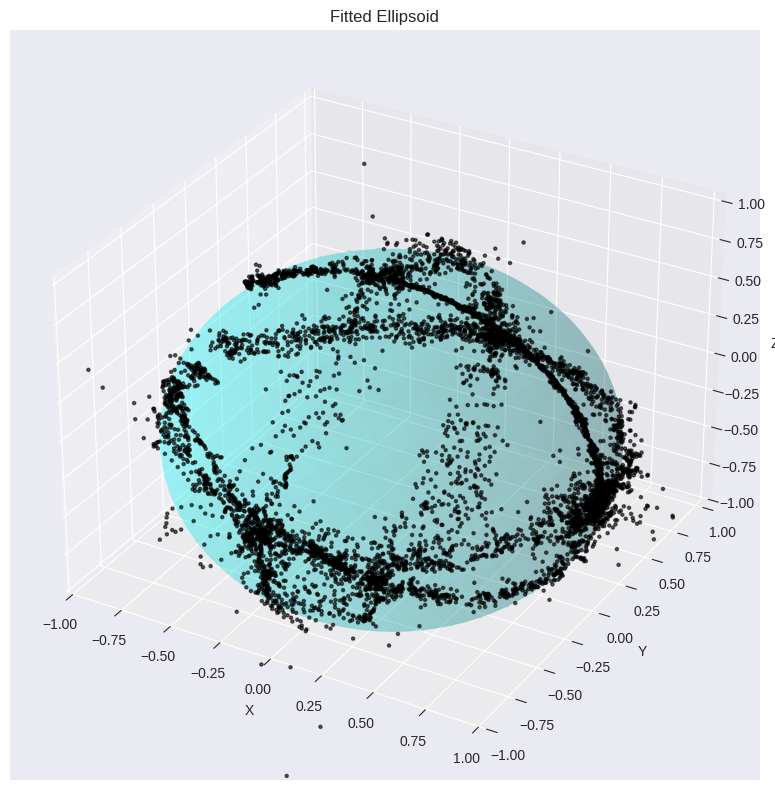

In [263]:
# Optional: pass in your raw data to overlay points
data = np.array([[d['ax'], d['ay'], d['az']] for d in data_log])

plot_ellipsoid(center, radii, rotation, raw_data=data)

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_ellipsoid_with_projections(center, radii, rotation, raw_data):
    """
    Plots:
    - Fitted 3D ellipsoid surface
    - Raw 3D IMU data
    - 2D projections (XY, XZ, YZ) showing both raw data and ellipsoid projection
    """

    # Generate ellipsoid surface points
    u = np.linspace(0, 2 * np.pi, 60)
    v = np.linspace(0, np.pi, 60)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))

    # Scale, rotate, and translate sphere to form ellipsoid
    sphere = np.stack((x, y, z), axis=-1)
    ellipsoid = sphere @ np.diag(radii) @ rotation.T + center
    X, Y, Z = ellipsoid[:, :, 0], ellipsoid[:, :, 1], ellipsoid[:, :, 2]

    # Flatten ellipsoid surface points for projection plotting
    ellipsoid_points = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

    # Extract raw data
    ax_vals = raw_data[:, 0]
    ay_vals = raw_data[:, 1]
    az_vals = raw_data[:, 2]

    # Setup figure and subplots manually
    fig = plt.figure(figsize=(12, 10))

    # 3D plot in position 1
    ax3d = fig.add_subplot(2, 2, 1, projection='3d')
    ax3d.plot_surface(X, Y, Z, rstride=2, cstride=2, color='cyan', alpha=0.3, linewidth=0)
    ax3d.scatter(ax_vals, ay_vals, az_vals, c='black', s=5, alpha=0.6)
    ax3d.set_title('3D Ellipsoid Fit')
    ax3d.set_xlabel('ax')
    ax3d.set_ylabel('ay')
    ax3d.set_zlabel('az')

    max_radius = np.max(radii)
    for axis in [ax3d.set_xlim, ax3d.set_ylim, ax3d.set_zlim]:
        axis(center[0] - max_radius, center[0] + max_radius)

    # Create other 2D subplots manually
    axs = [ax3d]
    for i in range(2, 5):  # subplot positions 2, 3, 4
        axs.append(fig.add_subplot(2, 2, i))

    # Define projections: (index_x, index_y, title, color)
    projections = [
        (0, 1, 'XY', 'green'),
        (0, 2, 'XZ', 'purple'),
        (1, 2, 'YZ', 'orange'),
    ]

    # Common axis limits for projections
    val = np.max(np.abs(raw_data)) + 0.2
    axis_lim = [-val, val]

    for k, (i, j, title, color) in enumerate(projections):
        ax = axs[k + 1]
        ax.scatter(raw_data[:, i], raw_data[:, j], c='black', s=10, alpha=0.6, label='Raw')
        ax.scatter(ellipsoid_points[:, i], ellipsoid_points[:, j], c=color, s=1, alpha=0.5, label='Ellipsoid')
        ax.set_xlabel(['ax', 'ay', 'az'][i])
        ax.set_ylabel(['ax', 'ay', 'az'][j])
        ax.set_title(f'{title} Projection')
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_xlim(axis_lim)
        ax.set_ylim(axis_lim)
        ax.legend(loc='lower right', fontsize='small')

    plt.tight_layout()
    plt.show()


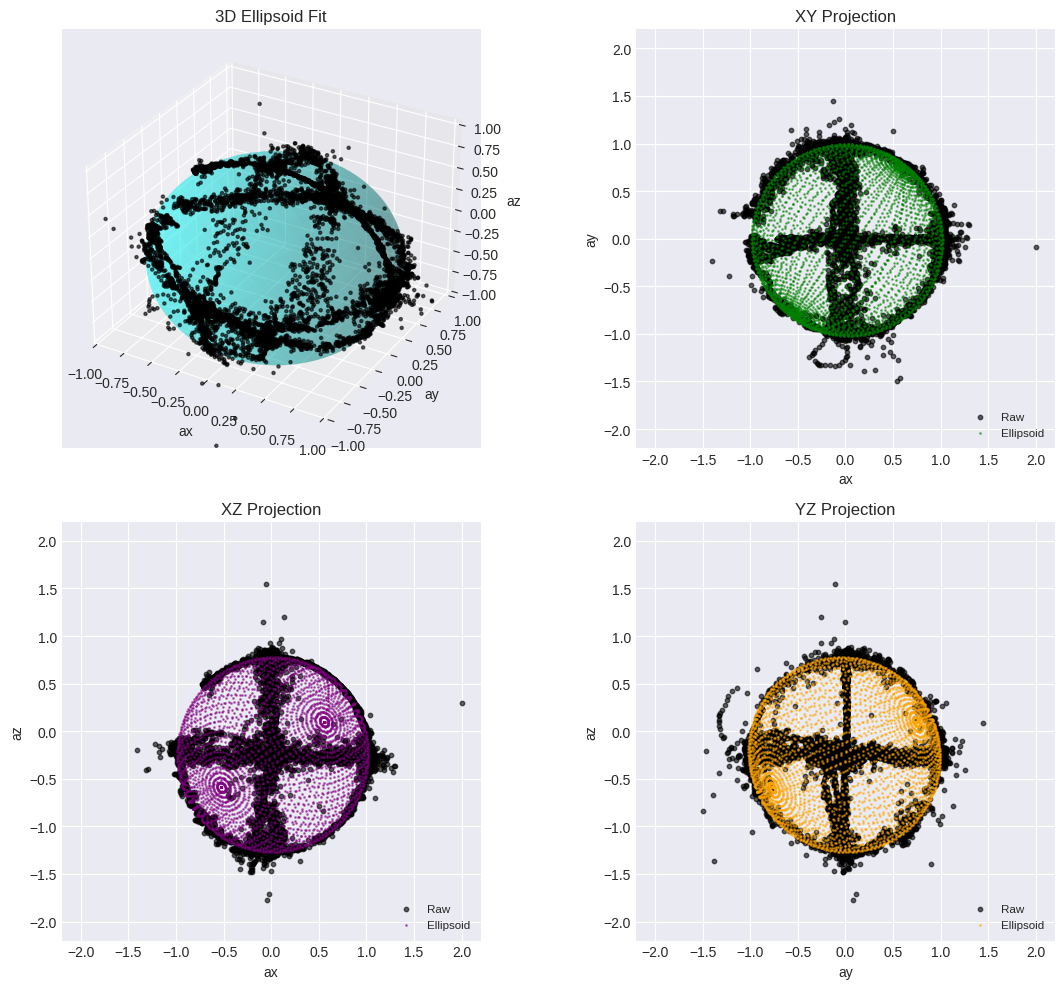

In [266]:
# Your IMU data
raw_data = np.array([[d['ax'], d['ay'], d['az']] for d in data_log])

# Call the function
plot_ellipsoid_with_projections(center, radii, rotation, raw_data)

In [267]:
import numpy as np

bias = center
#radii
R = rotation

# Correction matrix (soft-iron)
M = R @ np.diag(1.0 / radii) @ R.T

def calibrate(raw):
    raw = np.asarray(raw)
    return (M @ (raw - bias).T).T


In [268]:
calibrate(data)

array([[ 0.99553772,  0.02007325, -0.04006789],
       [ 0.9963694 ,  0.01815032, -0.03962334],
       [ 0.99611908,  0.01781462, -0.03772357],
       ...,
       [ 0.99496295,  0.01246283, -0.03089991],
       [ 0.99533606,  0.01420253, -0.02825558],
       [ 0.99740248,  0.01433055, -0.02897263]], shape=(7897, 3))

In [197]:
#data_clean[:10]
data_clean = data_log

In [198]:
az = [v['az'] for v in data_clean]

In [199]:
np.min(az)

np.float64(-1.2899169921875)

In [200]:
np.max(az)

np.float64(0.8994140625)

In [201]:
np.max(az) - np.min(az)

np.float64(2.1893310546875)

In [269]:
import numpy as np

def fit_ellipsoid_9point(points):
    """Minimal 9-point algebraic ellipsoid fit."""
    x, y, z = [points[:, i][:, None] for i in range(3)]
    D = np.hstack([x*x, y*y, z*z, x*y, x*z, y*z, x, y, z, np.ones_like(x)])
    _, _, vh = np.linalg.svd(D, full_matrices=False)
    v = vh.T[:, -1]
    return v  # raw coefficients

def algebraic_distance(v, pts):
    """Compute algebraic distance of points to ellipsoid defined by v."""
    x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]
    A, B, C, D, E, F, G, H, I, J = v
    return (
        A*x*x + B*y*y + C*z*z + D*x*y + E*x*z + F*y*z + G*x + H*y + I*z + J
    )

def ransac_ellipsoid(data, n_iter=1000, thresh=0.002, min_inliers=0.6):
    best_v = None
    best_inliers = []
    N = data.shape[0]

    for _ in range(n_iter):
        # Random 9 unique points
        idx = np.random.choice(N, 9, replace=False)
        try:
            v = fit_ellipsoid_9point(data[idx])
        except np.linalg.LinAlgError:
            continue  # skip degenerate sample

        # Compute distances
        d = np.abs(algebraic_distance(v, data))
        inliers = np.where(d < thresh)[0]

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_v = v

    # Refit with all inliers
    if len(best_inliers) / N < min_inliers:
        print("Warning: too few inliers, calibration might be poor.")
        print("Number of inliers: {}".format(len(best_inliers)))

    inlier_points = data[best_inliers]
    v_final = fit_ellipsoid_9point(inlier_points)

    return v_final, inlier_points


In [270]:
import numpy as np

# Suppose your list is called data_log
data = np.array([[d['ax'], d['ay'], d['az']] for d in data_log])

In [332]:
v_best, inliers = ransac_ellipsoid(data, n_iter=20000, thresh=0.06, min_inliers=0.6)
center, radii, R = fit_ellipsoid_constrained(inliers)

print("Bias:", center)
print("Radii:", radii)
print("Rotation:\n", R)


Bias: [ 0.01979673 -0.00530971 -0.23805808]
Radii: [1.0191744  1.00112323 0.9929984 ]
Rotation:
 [[-0.10992639 -0.90852035 -0.40312151]
 [-0.08983298  0.4130009  -0.9062893 ]
 [ 0.98987182 -0.0634115  -0.12701479]]


In [333]:
print(len(data))
print(len(inliers))

7897
6969


In [288]:
data[:10]

array([[ 1.01708984e+00, -1.58691406e-03, -2.84057617e-01],
       [ 1.01794434e+00, -3.54003906e-03, -2.83569336e-01],
       [ 1.01770020e+00, -3.90625000e-03, -2.81616211e-01],
       [ 1.01843262e+00, -4.15039062e-03, -2.81372070e-01],
       [ 1.01782227e+00, -1.95312500e-03, -2.86132812e-01],
       [ 1.01782227e+00, -1.83105469e-03, -2.83691406e-01],
       [ 1.02038574e+00, -2.80761719e-03, -2.80029297e-01],
       [ 1.01916504e+00, -2.56347656e-03, -2.84545898e-01],
       [ 1.01965332e+00, -1.70898438e-03, -2.80761719e-01],
       [ 1.01757812e+00, -2.44140625e-04, -2.82592773e-01]])

In [289]:
inliers[:10]

array([[ 1.01708984e+00, -1.58691406e-03, -2.84057617e-01],
       [ 1.01794434e+00, -3.54003906e-03, -2.83569336e-01],
       [ 1.01770020e+00, -3.90625000e-03, -2.81616211e-01],
       [ 1.01843262e+00, -4.15039062e-03, -2.81372070e-01],
       [ 1.01782227e+00, -1.95312500e-03, -2.86132812e-01],
       [ 1.01782227e+00, -1.83105469e-03, -2.83691406e-01],
       [ 1.02038574e+00, -2.80761719e-03, -2.80029297e-01],
       [ 1.01916504e+00, -2.56347656e-03, -2.84545898e-01],
       [ 1.01965332e+00, -1.70898438e-03, -2.80761719e-01],
       [ 1.01757812e+00, -2.44140625e-04, -2.82592773e-01]])

# Data Conditioning (see Horn's closed-form absolute orientation)

In [281]:
import numpy as np

def fit_ellipsoid_constrained(data):
    """
    Fits an ellipsoid to 3D points using an algebraic (constrained) fit,
    with Horn-style data conditioning (centering and scaling)
    for numerical stability.

    Returns:
        center:   (3,) ellipsoid center in original coordinates
        radii:    (3,) semi-axis lengths (a, b, c), sorted descending
        rotation: (3,3) rotation matrix (columns = principal axes)
    """
    data = np.asarray(data)

    # ----------------------------
    # 1. Data conditioning
    # ----------------------------
    mean = np.mean(data, axis=0)
    scale = np.std(data)
    if scale == 0:
        raise ValueError("Degenerate data: zero variance.")
    
    data_n = (data - mean) / scale  # normalized coordinates

    # ----------------------------
    # 2. Build design matrix
    # ----------------------------
    x = data_n[:, 0][:, None]
    y = data_n[:, 1][:, None]
    z = data_n[:, 2][:, None]

    # General quadric: Axx + Byy + Czz + Dxy + Exz + Fyz + Gx + Hy + Iz + J = 0
    D = np.hstack([x*x, y*y, z*z, x*y, x*z, y*z, x, y, z, np.ones_like(x)])

    # ----------------------------
    # 3. Solve algebraic system via SVD
    # ----------------------------
    _, _, vh = np.linalg.svd(D, full_matrices=False)
    v = vh.T[:, -1]

    # Unpack parameters
    Q = np.array([
        [v[0],   v[3]/2, v[4]/2],
        [v[3]/2, v[1],   v[5]/2],
        [v[4]/2, v[5]/2, v[2]]
    ])
    u = np.array([v[6], v[7], v[8]])
    f = v[9]

    if np.linalg.matrix_rank(Q) < 3:
        raise ValueError("Fitted quadric is degenerate (Q not full rank).")

    # ----------------------------
    # 4. Compute center in normalized space
    # ----------------------------
    center_n = -0.5 * np.linalg.solve(Q, u)
    k = center_n @ Q @ center_n - f

    eigvals = np.linalg.eigvalsh(Q)
    if k <= 0 or np.any(eigvals <= 0):
        Q, u, f = -Q, -u, -f
        center_n = -0.5 * np.linalg.solve(Q, u)
        k = center_n @ Q @ center_n - f
        eigvals = np.linalg.eigvalsh(Q)
    if k <= 0 or np.any(eigvals <= 0):
        raise ValueError("Fitted surface is not an ellipsoid (k<=0 or Q not PD).")

    # ----------------------------
    # 5. Diagonalize Q for axes and rotation
    # ----------------------------
    evals, evecs = np.linalg.eigh(Q)
    radii_n = np.sqrt(k / evals)

    # Sort axes largest→smallest
    order = np.argsort(radii_n)[::-1]
    radii_n = radii_n[order]
    rotation_n = evecs[:, order]

    # ----------------------------
    # 6. Transform results back to original coordinates
    # ----------------------------
    # Scaling and centering transformation: x = scale * x_n + mean
    # For the center:
    center = mean + scale * center_n

    # Radii scale with the same factor:
    radii = scale * radii_n
    rotation = rotation_n  # same rotation in both spaces (isotropic scaling)

    return center, radii, rotation


In [282]:
data = np.array([[d['ax'], d['ay'], d['az']] for d in data_log])
center, radii, rotation = fit_ellipsoid_constrained(data)

print("Center:", center)
print("Radii:", radii)
print("Rotation matrix:\n", rotation)

Center: [ 0.01589723 -0.01380146 -0.24395956]
Radii: [1.03890735 1.01217284 0.9990627 ]
Rotation matrix:
 [[ 0.14893148 -0.74341801 -0.65203456]
 [-0.49961905  0.51246109 -0.69840134]
 [ 0.85334648  0.42978284 -0.29510422]]


In [334]:
#data = np.array([[d['ax'], d['ay'], d['az']] for d in data_log])
center, radii, rotation = fit_ellipsoid_constrained(inliers)

print("Center:", center)
print("Radii:", radii)
print("Rotation matrix:\n", rotation)

Center: [ 0.01979673 -0.00530971 -0.23805808]
Radii: [1.0191744  1.00112323 0.9929984 ]
Rotation matrix:
 [[-0.10992639 -0.90852035 -0.40312151]
 [-0.08983298  0.4130009  -0.9062893 ]
 [ 0.98987182 -0.0634115  -0.12701479]]


In [335]:
#plot_ellipsoid(center, radii, rotation, raw_data=inliers)

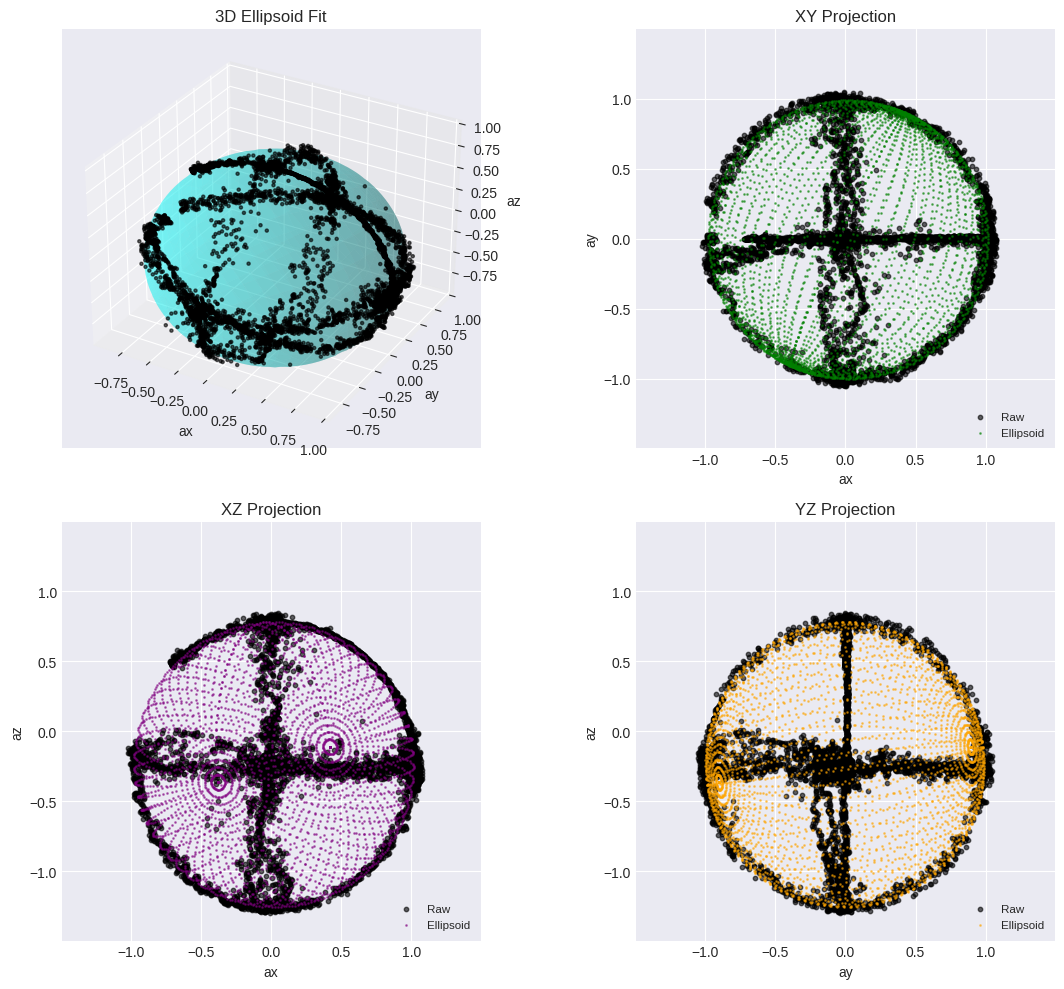

In [336]:
# Call the function
plot_ellipsoid_with_projections(center, radii, rotation, raw_data=inliers)